# Deprecated

## Reason
poor performance


# Split on Silence

* Split audio phrase (Korean) by silence, and remove the silent sections.
* Map the hangul characters to the matching audio (manual process).


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Transcription and Audio File Location

In [2]:
transcript_file = 'data/korean-single-speaker/transcript.v.1.4.txt'
tr_df = pd.read_csv(transcript_file, sep="|", names=["audio_file", "tr_w_num", "tr_syl", "tr_char", "dur", "en"])



Inpsecting the transcript there are 3 different transcriptions.

| <!-- -->    | <!-- -->    |
|-------------|-------------|
|tr_w_num|Keeps numerics in number form|
|tr_syl|String encoding is syllable by syllable|
|tr_char|String encoding is character by character|



In [3]:
# Since we are not interested in numerics as numbers, we drop that column
tr_df = tr_df.drop(columns=['tr_w_num'])
tr_df

,audio_file,tr_syl,tr_char,dur,en
0,1/1_0000.wav,그는 괜찮은 척하려고 애쓰는 것 같았다.,그는 괜찮은 척하려고 애쓰는 것 같았다.,3.5,He seemed to be pretending to be okay.
1,1/1_0001.wav,그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.,그녀의 사랑을 얻기 위해 애썼지만 헛수고ᄋ...,4.0,I tried in vain to win her love.
2,1/1_0002.wav,용돈을 아껴 써라.,용돈을 아껴 써라.,1.8,Save your pocket money.
3,1/1_0003.wav,그는 아내를 많이 아낀다.,그는 아내를 많이 아낀다.,2.3,He cherishes his wife.
4,1/1_0004.wav,그 애 전화번호 알아?,그 애 전화번호 알아?,1.3,Do you know his number?
...,...,...,...,...,...
12849,4/4_5627.wav,깨진 유리 조각에 손가락을 벴어요.,깨진 유리 조각에 손가락을 벴어요.,3.9,I cut my finger on a piece of broken glass.
12850,4/4_5628.wav,아드님이 친구들과 야구를 하다 유리창을 깼어요.,아드님이 친구들과 야구를 하다 유리창을 ᄁ...,5.4,Your son was playing baseball with his friends...
12851,4/4_5629.wav,일찍 신청하는 사람이 유리할 거야.,일찍 신청하는 사람이 유리할 거야.,3.7,Early applicants will be given advantages.
12852,4/4_5630.wav,이 두 소설은 줄거리가 유사해요.,이 두 소설은 줄거리가 유사해요.,3.5,These two novels are much alike in their synop...


In [169]:
# # This code only needs to be run once. It creates the initial chunk dataframes

# base_dir = 'data/korean-single-speaker/kss_chunks'
#

#
# # Initial Creation of Chunk Progress DataFrame
# # This dataframe will be used to track which source audio files have been processed into chunks.
# chunk_progress_df = tr_df[['audio_file']].rename({'audio_file': 'source'}, axis='columns')
# # chunk_df.columns = ['source_file', 'src_syl', 'src_char']
# chunk_progress_df['chunks_processed'] = None
#
# chunk_progress_df['tr_processed'] = False
# chunk_progress_df[['src_syl', 'src_char']] = tr_df[['tr_syl', 'tr_char']]
# chunk_progress_df
#
# # Initial Creation fo Chunk Dataframe
# # This dataframe will point to the audio chunk files
# chunk_df = pd.DataFrame(columns=['chunk_file', 'is_valid', 'chunk_char', 'src_file', 'src_char' ])
# chunk_df
#
# # Create the initial csv files
#
#
# chunk_progress_df.to_csv(f'{base_dir}/chunk_progress.csv', index=False)
# chunk_df.to_csv(f'{base_dir}/chunk.csv', index=False)



## Audio Analysis

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


In [4]:
# /kaggle/input/korean-single-speaker-speech-dataset/transcript.v.1.4.txt
# /kaggle/input/korean-single-speaker-speech-dataset/kss/1/1_0845.wav (example)

# from comet_ml import Experiment
import librosa
import librosa.display
from scipy.io import wavfile as wav
import IPython


## Class for removing silence

In [5]:
import numpy.ma as ma
from sklearn.cluster import KMeans


class Silencer:

    def __init__(self, audio, levels=5, smooth_length=512):
        self.audio = audio
        self.levels = levels
        self.kmeans = KMeans(n_clusters=levels, random_state=0).fit(np.abs(self.audio.reshape(-1, 1)))
        self.useful_audio_mask = self.mask_useful_audio(levels)
        self.smoothed_silence_mask = self.smooth_silence_mask(self.useful_audio_mask, smooth_length)
        self.forced_silence = np.where(self.smoothed_silence_mask.mask, 0, self.audio)
        self.silence_runs = self.find_silence_runs(self.smoothed_silence_mask)

    @staticmethod
    def rolling_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w

    @staticmethod
    def zero_runs(a):
        # Create an array that is 1 where a is 0, and pad each end with an extra 0.
        iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        # Runs start and end where absdiff is 1.
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        return ranges

    @staticmethod
    def smooth_silence_mask(audio_mask, window, silence_threshold=0.05):
        """
        Takes the audio mask and does rolling averages over the window length.
        This effectively ignores short lived zeros (silences) and only silence of a
        significant duration (as determined by window) is masked.

        :param audio_mask: Mask over audio samples, True -> sample is not silence, False -> sample is silence.
        :return: the mask after smoothing (removing spurious silences)
        """
        smoothed_silence_ra = Silencer.rolling_average(audio_mask, window)
        return ma.masked_less(smoothed_silence_ra, silence_threshold)


    def mask_useful_audio(self, levels=5):
        """ Find the useful audion (non-silence) in an audio clip by splitting the audio into different levels,
            and treating the lowest level as silence (the mask will be false for these areas)

            Currently uses K-means, but this is possibly overkill. Finding the max amplitude and
            dividing by number of levels, and treating the lowest level as silence might work just as well
            but be more efficient.

            Args:
                audio: numpy array of audio data
                levels: The number of levels to split the audio into.

            Returns:
                The return value. True for success, False otherwise.

        """


        # find minimum audio value (quietest sample)
        audio_min_idx = np.argmin(np.abs(self.audio))

        # find the cluster that sample is assigned to
        silence_cluster = self.kmeans.labels_[audio_min_idx]

        # Convert clusters to boolean, with silence being true, and audio being false
        return np.array(self.kmeans.labels_!= silence_cluster)

    # def forced_silence(self, smoothed_silence_mask):
    #     return np.where(smoothed_silence_mask.mask, 0, self.audio)

    def find_silence_runs(self, smoothed_silence_mask):
        """
        Finds start and end indices for stretches of silence in the audio.
        :param audio:
        :param smoothed_silence_mask:
        :return: matrix in the folling format:
         [[ 1st_zeros_start_idx, 1st_zeros_end_idx],
          [ 2nd_zeros_start_idx, 2nd_zeros_end_idx],
          ...
          [ last_zeros_start_idx, last_zeros_end_idx]]
        """
        return self.zero_runs(self.forced_silence)

    def remove_silence(self, silence_pad=0):
        """
        Remove silence from audio stream.
        :param audio:
        :param silence_pad: Replaces a stretch of silence with this number of samples of added silence.
        :return:
        """
         # np.roll(A, -1) will convert the above into:
         # [[ 1st_zeros_end_idx, 2nd_zeros_start_idx ],
         #  [ 2nd_zeros_end_idx, 3rd_zeros_start_idx ],
         # ...
         # [ last_zeros_end_idx, 1st_zeros_start_idx]]
        audio_word_idxs = np.roll(self.silence_runs, -1)[:-1,:]
        return [np.pad(self.audio[start:end], (0, silence_pad), 'constant') for (start, end) in audio_word_idxs]

In [124]:
import textgrid


tg_dir = 'data/korean-single-speaker/kss/1'
tg_file = '1_0003.TextGrid'
audio_file = '1_0003.wav'
tg_path = f'{tg_dir}/{tg_file}'
audio_path = f'{tg_dir}/{audio_file}'
tg = textgrid.TextGrid.fromFile(tg_path)

display(tg)

TextGrid(None, [IntervalTier(char, [Interval(0.0, 0.08071, 0), Interval(0.08071, 0.12089, ᄀ), Interval(0.12089, 0.15231, ᅳ), Interval(0.15231, 0.20956, ᄂ), Interval(0.20956, 0.30481, ᅳ), Interval(0.30481, 0.48924, ᆫ), Interval(0.48924, 0.75129, 0), Interval(0.75129, 0.88808, 아), Interval(0.88808, 0.94573, ᄂ), Interval(0.94573, 1.02123, ᅢ), Interval(1.02123, 1.06647, ᄅ), Interval(1.06647, 1.15844, ᅳ), Interval(1.15844, 1.23614, ᆯ), Interval(1.23614, 1.24294, ᄆ), Interval(1.24294, 1.39564, ᅡ), Interval(1.39564, 1.4555, ᆭ), Interval(1.4555, 1.5327, 이), Interval(1.5327, 1.75352, 아), Interval(1.75352, 1.78153, ᄁ), Interval(1.78153, 1.83571, ᅵ), Interval(1.83571, 1.97293, ᆫ), Interval(1.97293, 1.98396, ᄃ), Interval(1.98396, 2.1979, ᅡ), Interval(2.1979, 2.30753, 0)]), IntervalTier(syl, [Interval(0.0, 0.08071, 0), Interval(0.08071, 0.15231, 그), Interval(0.15231, 0.48924, 는), Interval(0.48924, 0.75129, 0), Interval(0.75129, 0.88808, 아), Interval(0.88808, 1.02123, 내), Interval(1.02123, 1

In [127]:
chunk_dir = 'data/korean-single-speaker/kss_chunks'
chunk_char_path = f'{chunk_dir}/chunk_char.csv'
chunk_char_list = [ [ivl.mark, ivl.minTime, ivl.maxTime, audio_path] for ivl in tg[0].intervals]

# display(chunk_char_list)

chunk_char_df = pd.DataFrame(chunk_char_list, columns=['char', 'start', 'stop', 'audio'])
# chunk_char_df.loc[len(chunk_char_df)] = chunk_char_list
display(chunk_char_df)

# APPEND to CSV
# chunk_char_df.to_csv(chunk_char_path, mode='a', header=False, index=False)

,char,start,stop,audio
0,0,0.00000,0.08071,data/korean-single-speaker/kss/1/1_0003.wav
1,ᄀ,0.08071,0.12089,data/korean-single-speaker/kss/1/1_0003.wav
2,ᅳ,0.12089,0.15231,data/korean-single-speaker/kss/1/1_0003.wav
3,ᄂ,0.15231,0.20956,data/korean-single-speaker/kss/1/1_0003.wav
4,ᅳ,0.20956,0.30481,data/korean-single-speaker/kss/1/1_0003.wav
5,ᆫ,0.30481,0.48924,data/korean-single-speaker/kss/1/1_0003.wav
6,0,0.48924,0.75129,data/korean-single-speaker/kss/1/1_0003.wav
7,아,0.75129,0.88808,data/korean-single-speaker/kss/1/1_0003.wav
8,ᄂ,0.88808,0.94573,data/korean-single-speaker/kss/1/1_0003.wav
9,ᅢ,0.94573,1.02123,data/korean-single-speaker/kss/1/1_0003.wav


In [128]:
chunk_syl_path = f'{chunk_dir}/chunk_syl.csv'
chunk_syl_list = [ [ivl.mark, ivl.minTime, ivl.maxTime, audio_path] for ivl in tg[1].intervals]
chunk_syl_df = pd.DataFrame(chunk_syl_list, columns=['syl', 'start', 'stop', 'audio'])

display(chunk_syl_df)
# APPEND to CSV
# chunk_syl_df.to_csv(chunk_syl_path, mode='a', header=False, index=False)

,syl,start,stop,audio
0,0,0.00000,0.08071,data/korean-single-speaker/kss/1/1_0003.wav
1,그,0.08071,0.15231,data/korean-single-speaker/kss/1/1_0003.wav
2,는,0.15231,0.48924,data/korean-single-speaker/kss/1/1_0003.wav
3,0,0.48924,0.75129,data/korean-single-speaker/kss/1/1_0003.wav
4,아,0.75129,0.88808,data/korean-single-speaker/kss/1/1_0003.wav
5,내,0.88808,1.02123,data/korean-single-speaker/kss/1/1_0003.wav
6,를,1.02123,1.23614,data/korean-single-speaker/kss/1/1_0003.wav
7,많,1.23614,1.45550,data/korean-single-speaker/kss/1/1_0003.wav
8,이,1.45550,1.53270,data/korean-single-speaker/kss/1/1_0003.wav
9,아,1.53270,1.75352,data/korean-single-speaker/kss/1/1_0003.wav


In [96]:

# Class to create consistently sized audio features.
class AudioFeature:

    def __init__(self, src_path, feature_secs=1.0):
        self.path = src_path
        self.audio, self.sr = librosa.load(src_path)
        self.feature_secs = feature_secs
        if feature_secs > self.secs():
            raise Exception('Feature duration cannot exceed audio duration')
        self.feature_samps = self.samples(feature_secs)

    def secs(self, num_samples=None):
        num_s = num_samples or len(self.audio)
        return num_s/self.sr

    def samples(self, secs=None):
        if secs is None :
            s = len(self.audio)
        else:
            s = int(secs * self.sr)
        return s

    def audio_interval(self, start_sec, end_sec):
        sample_start = self.samples(start_sec)
        sample_end = self.samples(end_sec)
        return self.audio[sample_start:sample_end]

    # Creates a consistently sized audio feature with the audio of interest in side
    # These features should be suitable for training.
    def feature_audio(self, mark_start, mark_end):
        mark_secs = mark_end - mark_start
        if mark_secs < 0:
            raise Exception('mark_start time cannot be after mark_end time')
        max_pad_secs = self.feature_secs - mark_secs
        if max_pad_secs < 0:
            raise Exception('feature duration seconds must be larger than the audio area of interest (defined by marks)')

        feature_start_secs = np.random.uniform(mark_start-max_pad_secs, mark_start)
        feature_start_sample = self.samples(feature_start_secs)
        feature_end_sample = feature_start_sample + self.feature_samps
        sample_idxs = range(feature_start_sample, feature_end_sample)
        print(len(sample_idxs))
        # mode=wrap allows us to handle out of range indices
        return self.audio.take(sample_idxs, mode='wrap')





def tmp_boundary_selector(df, filter, idx):
    return (df[filter]['start'].values[idx], df[filter]['stop'].values[idx])
# Audio features
def audio_feature(src_path, mark_start, mark_end):
    audio, sr = librosa.load(src_path)
    mark_sample_start = int(mark_start * sr)
    mark_sample_end = int(mark_end * sr)
    print((mark_sample_start, mark_sample_end))
    return (audio[mark_sample_start:mark_sample_end], sr)
    # IPython.display.Audio(audio, rate=sr)

af = AudioFeature(audio_path, 1.0)
chunk_filter = chunk_char_df['char'] == 'ᄀ'
ch_start, ch_end = tmp_boundary_selector(chunk_char_df, chunk_filter, 0)
# a_, sr_ = audio_feature(audio_path, ch_start, ch_end)
# mark_audio =

# IPython.display.Audio(af.mark_audio(ch_start, ch_end), rate=af.sr)
IPython.display.Audio(af.feature_audio(0,0.5), rate=af.sr)
# print(len(a_)/sr_)

22050


## Class for processing audio into chunks

In [10]:
import os
import soundfile as sf

class ChunkProcessor:
    def __init__(self, progress_df, chunk_df, base_dir):
        self.progress_df = progress_df
        self.chunk_df = chunk_df
        self.base_dir = base_dir

    @staticmethod
    def get_silencer_and_sr(data_dir, f):
        src = f'{data_dir}/{f}'
        print(f'source file: {src}')
        audio, sr = librosa.load(src)
        return Silencer(audio), sr

    def process(self, data_dir, batch_size=1):
        audio_files_to_process = self.progress_df[self.progress_df['chunks_processed'].isnull()][0:batch_size]

        for f, tr  in zip(audio_files_to_process['source'], audio_files_to_process['src_char']):
            src = f'{data_dir}/{f}'
            silencer, sr = self.get_silencer_and_sr(data_dir, f)
            chunks = silencer.remove_silence(0)
            print(f'Number of Chunks found: {len(chunks)}')
            [self.save_chunk(src, idx, chunk, sr, tr) for idx, chunk in enumerate(chunks)]
            # All chunks have been saved, so mark this source file
            # print(chunk_progress_df[chunk_progress_df['source'] == f])
            # df.loc[(df.Event == 'Dance'),'Event']='Hip-Hop'
            self.progress_df.loc[(chunk_progress_df['source'] == f), 'chunks_processed'] = True

    def save_chunk(self, src, idx, chunk, sr, tr):
        idx_f = f"{idx:03d}"
        src_base = os.path.basename(src)
        chunk_file_name = src_base.replace('.wav', f'_{idx_f}.wav')
        chunk_path = f'{self.base_dir}/audio/{chunk_file_name}'
        sf.write(chunk_path, chunk, sr)
        new_row = {'chunk_file': chunk_path, 'src_file': src, 'src_char': tr }
        self.chunk_df = self.chunk_df.append(new_row, ignore_index=True)


## Process audio into chunks

### Load current chunks and progress

In [129]:
base_dir = 'data/korean-single-speaker/kss_chunks'

# chunk_progress_df = pd.read_csv(f'{base_dir}/chunk_progress.csv')
# chunk_df = pd.read_csv(f'{base_dir}/chunk.csv')
# print(chunk_df)
chunk_char_df = pd.read_csv(f'{base_dir}/chunk_char.csv')
display(chunk_char_df['char'].value_counts())

chunk_syl_df = pd.read_csv(f'{base_dir}/chunk_syl.csv')
display(chunk_syl_df['syl'].value_counts())

0     20
ᅡ     11
ᆫ     10
ᅳ      8
ᄀ      6
ᅥ      5
아     4
ᄅ      4
ᆻ      4
ᄃ      4
ᅩ      3
ᅵ      3
ᅧ      3
ᆺ      3
ᆯ      3
ᆨ      3
으     3
ᄂ      3
ᆭ      2
ᆼ      2
ᄁ      2
ᄊ      2
ᄆ      2
ᄒ      2
ᄎ      2
애     2
요     1
의     1
ᄉ      1
ᆮ      1
어     1
해     1
ᆨ~     1
ᅮ      1
이     1
ᅫ      1
~ᇀ     1
ᅢ      1
위     1
ᄌ      1
여     1
~ᆨ     1
ᇀ~     1
Name: char, dtype: int64

0        20
다        3
그        3
아        3
고        2
는         2
애        2
을       2
사        1
지        1
이        1
같~      1
를       1
라        1
~ᇀ았     1
만       1
찮       1
껴        1
것       1
기        1
얻       1
해        1
내        1
괜       1
돈       1
는       1
써        1
~ᆨ하      1
려        1
용       1
헛       1
위        1
였       1
은       1
많       1
척~      1
수        1
의        1
낀       1
썼       1
녀        1
쓰         1
랑       1
Name: syl, dtype: int64

### Process a new batch

Find unprocessed phrases and split them on silence, and update the csv files.

In [113]:
data_dir = 'data/korean-single-speaker/kss'

batch_size = 1

cp = ChunkProcessor(chunk_progress_df, chunk_df, base_dir)

cp.process(data_dir, batch_size)

cp.progress_df.to_csv(f'{base_dir}/chunk_progress.csv', index=False)
cp.chunk_df.to_csv(f'{base_dir}/chunk.csv', index=False)


source file: data/korean-single-speaker/kss/1/1_0010.wav
Number of Chunks found: 6


In [12]:
display(chunk_df.tail())
chunk_progress_df[8:-1].head()

,chunk_file,is_valid,main_phon,pre_phon,post_phon,src_file,src_char
61,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,한,NaN,NaN,data/korean-single-speaker/kss/1/1_0008.wav,나는 살아오면서 감기를 앓은 적이 한 ᄇ...
62,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,번,NaN,NaN,data/korean-single-speaker/kss/1/1_0008.wav,나는 살아오면서 감기를 앓은 적이 한 ᄇ...
63,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,도 어,NaN,ᆹ,data/korean-single-speaker/kss/1/1_0008.wav,나는 살아오면서 감기를 앓은 적이 한 ᄇ...
64,data/korean-single-speaker/kss_chunks/audio/1_...,1.0,다,ᆹ,NaN,data/korean-single-speaker/kss/1/1_0008.wav,나는 살아오면서 감기를 앓은 적이 한 ᄇ...
65,data/korean-single-speaker/kss_chunks/audio/1_...,0.0,NaN,NaN,NaN,data/korean-single-speaker/kss/1/1_0008.wav,나는 살아오면서 감기를 앓은 적이 한 ᄇ...


,source,chunks_processed,tr_processed,src_syl,src_char
5,1/1_0005.wav,True,True,차에 대해 잘 아세요?,차에 대해 잘 아세요?
6,1/1_0006.wav,True,True,거기 도착하면 나한테 알려 줘.,거기 도착하면 나한테 알려 줘.
7,1/1_0007.wav,True,True,그들은 내가 시험에 떨어졌다고 알려 왔다.,그들은 내가 시험에 떨어졌다고 알려 왔다.
8,1/1_0008.wav,True,True,나는 살아오면서 감기를 앓은 적이 한 번도 없다.,나는 살아오면서 감기를 앓은 적이 한 ᄇ...
9,1/1_0009.wav,True,False,사흘 동안 심하게 몸살을 앓았어요.,사흘 동안 심하게 몸살을 앓았어요.


#### Plot silence markers on last processed audio

In [13]:
last_processed = chunk_progress_df[chunk_progress_df['chunks_processed'] == True].tail(1)
display(last_processed.tail())

,source,chunks_processed,tr_processed,src_syl,src_char
9,1/1_0009.wav,True,False,사흘 동안 심하게 몸살을 앓았어요.,사흘 동안 심하게 몸살을 앓았어요.


In [14]:
last_proc_f = last_processed['source'].values[-1]
lp_silencer, lp_sr = ChunkProcessor.get_silencer_and_sr(data_dir, last_proc_f)
lp_word_list = lp_silencer.remove_silence(0)
lp_padded_audio_word_list = lp_silencer.remove_silence(5000)


source file: data/korean-single-speaker/kss/1/1_0009.wav


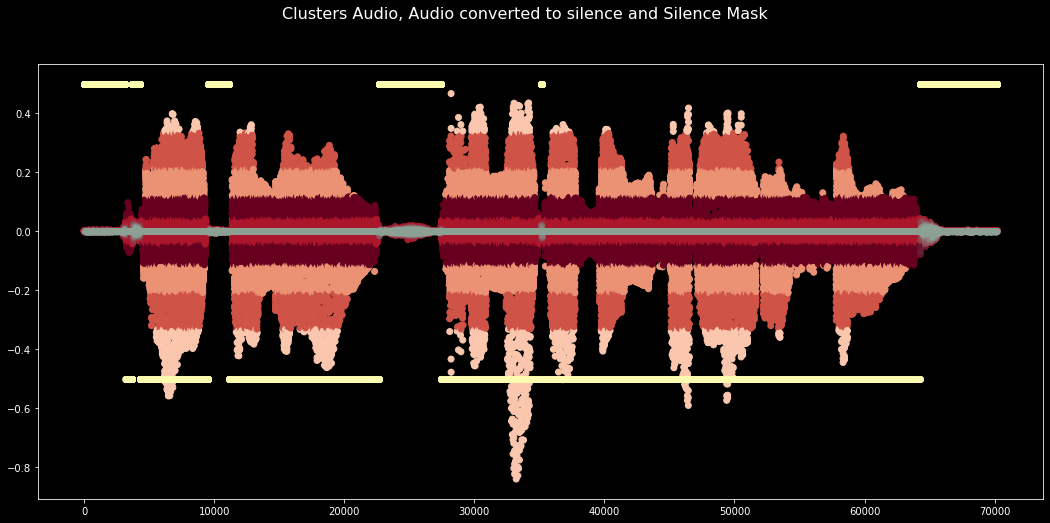

In [15]:
import matplotlib.cm as cm

x_ = np.arange(lp_silencer.audio.shape[0])
c_ = lp_silencer.kmeans.labels_
cmap = cm.get_cmap('RdBu', 12)
colors = cmap(np.arange(0,cmap.N))

fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('Clusters Audio, Audio converted to silence and Silence Mask', fontsize=16)
ax1.scatter(x_, lp_silencer.audio, c=colors[c_], alpha=1)
ax1.scatter(x_, lp_silencer.audio-lp_silencer.forced_silence, alpha=0.02)
ax1.scatter(x_, lp_silencer.smoothed_silence_mask.mask-0.5, alpha=0.25)
plt.show()


In [16]:
IPython.display.Audio(lp_silencer.forced_silence, rate=lp_sr)

In [17]:
IPython.display.Audio(np.concatenate(lp_word_list), rate=lp_sr)

In [18]:
IPython.display.Audio(np.concatenate(lp_padded_audio_word_list), rate=lp_sr)